# Self Driving Car Engineer
## Project: Behavioral Cloning
***
In this project, it is aimed to drive a car autonomously in a simulator

### Step 0: The data is loaded

In [1]:
#Importing useful libraries
import cv2 
import numpy as np
import pandas as pd

#Information of data is loaded and converted into a numpy array
data = pd.read_csv('driving_log.csv')
data = data.values

### Step 1: Defining image transformation functions

In [20]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV) #convert image into HSV format
    random_bright = 0.2 + np.random.uniform() #add some noise
    image1[:,:,2] = image1[:,:,2]*random_bright #multiply by it 
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB) #to get a different brightness
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2 #angle value is picked from (-angle/2, angle/2)
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1) #image is rotated

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2#translation value is picked from (-trans_range/2, trans_range/2)
    tr_y = trans_range*np.random.uniform()-trans_range/2#translation value is picked from (-trans_range/2, trans_range/2)
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]]) #image is translated

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2 #shear value is picked from (5-shear_range/2, 5+shear_range/2)
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2 #shear value is picked from (20-shear_range/2, 20+shear_range/2)
    
    # Brightness 
    #Each process is applied respectively
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    img = augment_brightness_camera_images(img)
    
    return img


### Step 2: Dataset Summary

- Features are 4D array containing raw pixel data of the road images, (num examples, width, height, channels)
- Labels are 1D array containing steering angles of the car, (num_examples,)

In [19]:
center_images = []
left_images = []
right_images = []
meas_center = []
meas_left = []
meas_right = []
correction_factor = 0.25 #we add this factor to the left images and subtract it to the right images
    

for i in range(data.shape[0]):
    #Third column of data shows steering angle
    meas = float(data[i,3])
    
    #If the angle is not zero, process can start
    if meas != 0:   
        image = cv2.imread(data[i,0].strip()) #image from center camera is read
        image_aug = transform_image(image,3.0,0.3,3.0) #new image is created by distorting the previous
        left_img = cv2.imread(data[i,1].strip()) #image from left camera is read
        right_img = cv2.imread(data[i,2].strip()) #image from right camera is read
        
        center_images.extend([image,image_aug]) #center images are stored in a list
        left_images.append(left_img) #left images are stored in a list
        right_images.append(right_img) #right images are stored in a list
        meas_center.extend([meas,meas]) #steering angles are stored in a list
        meas_left.append(meas + correction_factor) #steering angles are stored in a list 
        meas_right.append(meas - correction_factor) #steering angles are stored in a list 


center_arr = np.array(center_images) #image list is converted into an array
center_flipped = np.fliplr(center_arr) #image list is converted into an array
left_arr = np.array(left_images) #image list is converted into an array
right_arr = np.array(right_images) #image list is converted into an array

meas_center_arr = np.array(meas_center) #measurement list is converted into an array
meas_flipped = -1 * meas_center_arr #measurement list belongs to flipped images is converted into an array
meas_left_arr = np.array(meas_left) #measurement list belongs to left images is converted into an array
meas_right_arr = np.array(meas_right) #measurement list belongs to right images is converted into an array

features = np.concatenate((center_arr, center_flipped, left_arr, right_arr)) #Features are constructed by bringing all images together
labels = np.concatenate((meas_center_arr, meas_flipped, meas_left_arr,meas_right_arr)) #Labels are constructed by bringing all images together

#Dataset is pretty balanced
print ("features.shape=",features.shape)
print ("labels.shape=",labels.shape)
print ("(labels > 0).shape=",sum(labels > 0))
print ("(labels < 0).shape=",sum(labels < 0))

features.shape= (22050, 160, 320, 3)
labels.shape= (22050,)
(labels > 0).shape= 11053
(labels < 0).shape= 10997


### Step 3: Visualizing the process

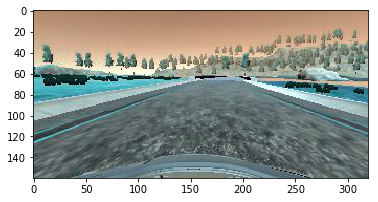

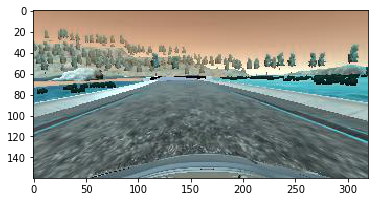

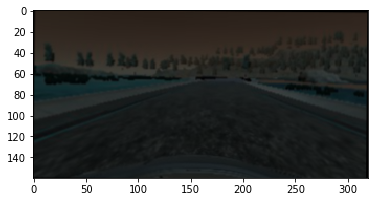

In [21]:
import matplotlib.pyplot as plt

image = features[0,:,:,:] #A sample from dataset
image_fl = np.fliplr(image) #It is flipped horizontally

plt.imshow(image) #show the original one
plt.show()

plt.imshow(image_fl) #show the flipped one
plt.show()

img_warped = transform_image(image,3.0,0.3,3.0) #the original image is distorted
plt.imshow(img_warped) #show the distorted one
plt.show()

### Step 4: Model Architecture

In this step keeping probability for dropout method, activation function and epochs variables are defined. According to the Nvidia architecture, model is constructed. Adam optimizer is used during the training process. Mean squared error is used as loss funcion. Data is split 80%-20% training and validation respectively. In each epoch data is shuffled. At the end of it, model file is saved to test the model on the simulator

In [22]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout
from keras.optimizers import Adam

dropout = 0.6
function = "relu"
epochs = 5

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(image_shape)))
model.add(Cropping2D(cropping=((75,20),(0,0))))
model.add(Conv2D(filters=24,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Conv2D(filters=36,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Conv2D(filters=48,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1, 1),activation=function))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1, 1),activation=function))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(1164,activation=function))
model.add(Dense(100,activation=function))
model.add(Dense(50,activation=function))
model.add(Dense(10,activation=function))
model.add(Dense(1))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse',optimizer=optimizer)
model.fit(features, labels, validation_split=0.2, shuffle=True, epochs=epochs)
model.save('model.h5')

Train on 17640 samples, validate on 4410 samples
Epoch 1/5
17640/17640 [==============================] - 199s - loss: 0.0277 - val_loss: 0.0680
Epoch 2/5
17640/17640 [==============================] - 181s - loss: 0.0203 - val_loss: 0.0540
Epoch 3/5
17640/17640 [==============================] - 175s - loss: 0.0189 - val_loss: 0.0447
Epoch 4/5
17640/17640 [==============================] - 180s - loss: 0.0176 - val_loss: 0.0477
Epoch 5/5
17640/17640 [==============================] - 182s - loss: 0.0170 - val_loss: 0.0461
